# Linear Regression with Predictions and Demographics
*Shaurya Gaur*

Are the predictions from our models correlated with certain variables that they should (not) be?

Adapted from [this lab exercise](https://github.com/Harshita0109/Sales-Prediction/blob/master/2048035_Lab3.ipynb).

In [6]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "/mnt/c/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
# NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

In [7]:
def calc_corr(df0, demo_col, models):
    allstats = []
    df = df0.dropna(subset=demo_col, axis=0)
    for m in models:
        predcol = df[models[m]]
        
        pearson_result = pearsonr(df[demo_col], predcol)
        pearson_lo, pearson_hi = pearson_result.confidence_interval(0.95)
        
        slr = LinearRegression()
        slr.fit(np.array(df[demo_col].tolist()).reshape(-1, 1), predcol)

        allstats.append({
            'PCC': pearson_result.statistic,
            'PCC p-val': pearson_result.pvalue,
            'PCC CI-lo': pearson_lo,
            'PCC CI-hi': pearson_hi,
            'SLR intercept': slr.intercept_,
            'SLR coefficient': slr.coef_[0], 
        })
    statdf = pd.DataFrame(allstats, index=models.keys())
    return statdf

## NLST: Load data

In [8]:
nlst_preds = pd.read_csv(f"{NLST_PREDS}/nlst_demov1_allmodels.csv")
nlst_preds = nlst_preds[(~nlst_preds['Thijmen_mean'].isna()) & (nlst_preds['InSybilTrain'] == False)]
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1881 entries, 7664 to 16016
Data columns (total 98 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientID              1881 non-null   int64  
 1   StudyDate              1881 non-null   int64  
 2   SeriesInstanceUID      1881 non-null   object 
 3   CoordX                 1881 non-null   float64
 4   CoordY                 1881 non-null   float64
 5   CoordZ                 1881 non-null   float64
 6   LesionID               1881 non-null   int64  
 7   NoduleType             1881 non-null   object 
 8   Spiculation            1881 non-null   bool   
 9   Diameter [mm]          1881 non-null   float64
 10  Age                    1881 non-null   int64  
 11  Gender                 1881 non-null   int64  
 12  FamilyHistoryLungCa    1881 non-null   bool   
 13  Emphysema              1881 non-null   bool   
 14  NoduleInUpperLung      1881 non-null   bool   
 15  Nodul

In [9]:
nlst_preds.isna().sum()

PatientID            0
StudyDate            0
SeriesInstanceUID    0
CoordX               0
CoordY               0
                    ..
sybil_year2          0
sybil_year3          0
sybil_year4          0
sybil_year5          0
sybil_year6          0
Length: 98, dtype: int64

In [10]:
with open(f'{NLST_PREDS}/nlst_demo_v1_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [11]:
nlst_democols['num']

{'demo': ['height', 'weight', 'Age'],
 'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']}

In [12]:
MODEL_TO_COL = {
    "Venkadesh": "DL",
    "de Haas Combined": "Thijmen_mean",
    # "de Haas Local": "Thijmen_local",
    # "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (shown nodule)": "Thijmen_global_show",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

## NLST: How are numerical demographic columns related with predictions?

### Demographic columns

height: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.029851,0.195630,-0.074947,0.015366,0.328223,-0.002391
de Haas Combined,-0.019658,0.394172,-0.064796,0.025562,0.252394,-0.001430
de Haas Global (shown nodule),-0.013097,0.570272,-0.058259,0.032119,0.205365,-0.001013
Sybil,-0.042606,0.064679,-0.087634,0.002595,0.097035,-0.000926
PanCan2b,-0.094915,0.000037,-0.139513,-0.049933,0.207975,-0.002304


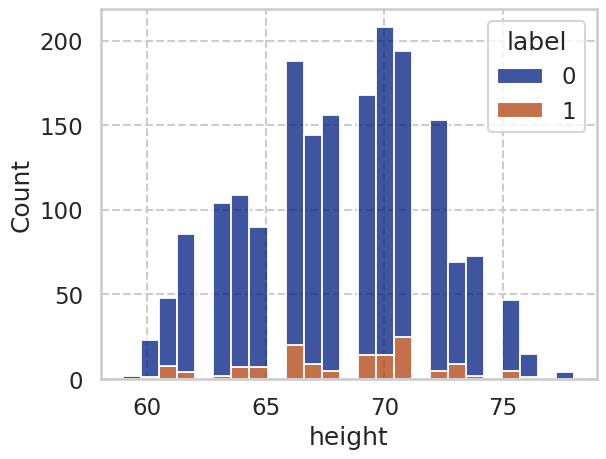

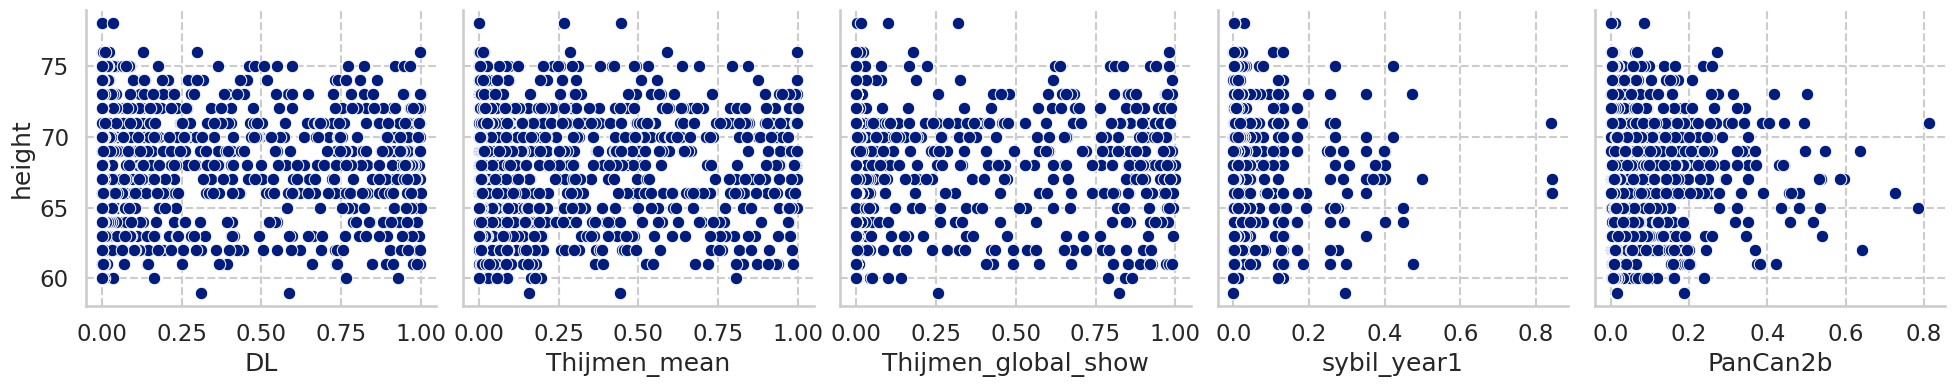

weight: 1 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.080793,4.540215e-04,-0.125543,-0.035715,0.275223,-0.000601
de Haas Combined,-0.073344,1.461192e-03,-0.118160,-0.028229,0.245448,-0.000495
de Haas Global (shown nodule),-0.089179,1.080092e-04,-0.133848,-0.044149,0.253375,-0.000640
Sybil,-0.028523,2.163983e-01,-0.073637,0.016707,0.044318,-0.000057
PanCan2b,-0.117369,3.338566e-07,-0.161719,-0.072545,0.099462,-0.000265


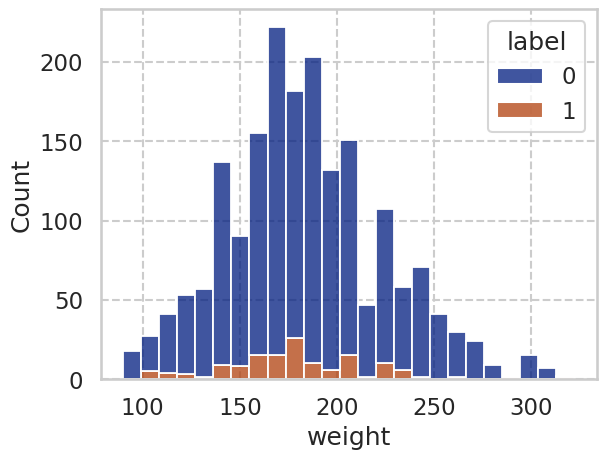

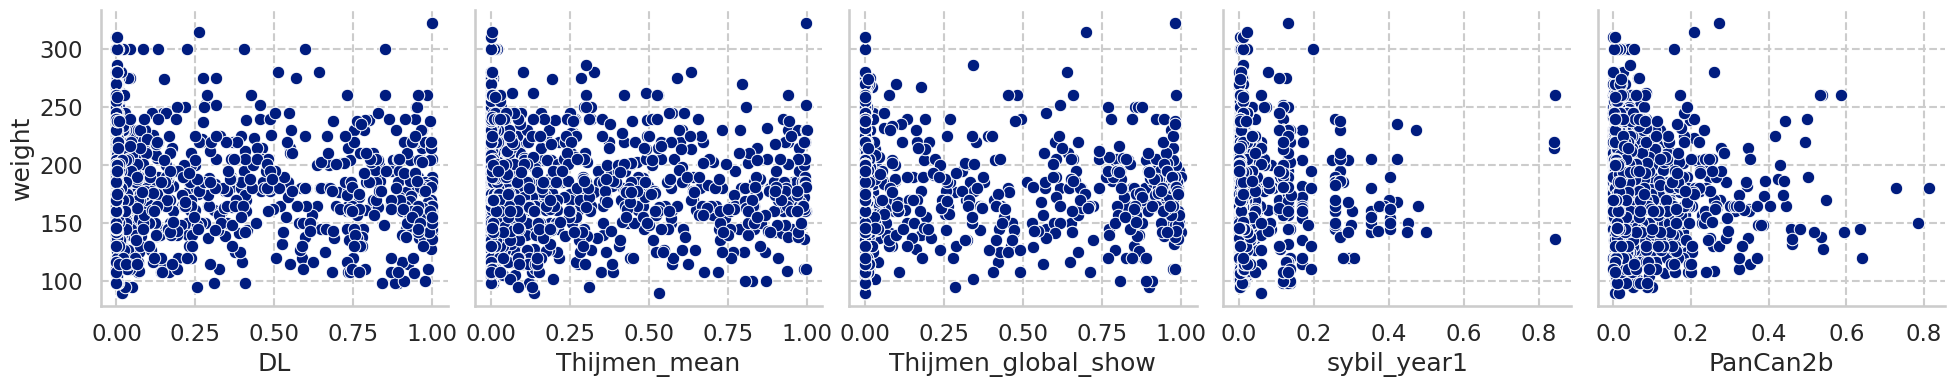

Age: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.072575,0.001635,0.027468,0.117386,-0.089144,0.004002
de Haas Combined,0.032802,0.155006,-0.012413,0.077883,0.050506,0.001643
de Haas Global (shown nodule),-0.005181,0.822327,-0.050366,0.040025,0.153870,-0.000276
Sybil,0.072361,0.001688,0.027253,0.117174,-0.034878,0.001083
PanCan2b,0.058991,0.010497,0.013831,0.103910,-0.011682,0.000986


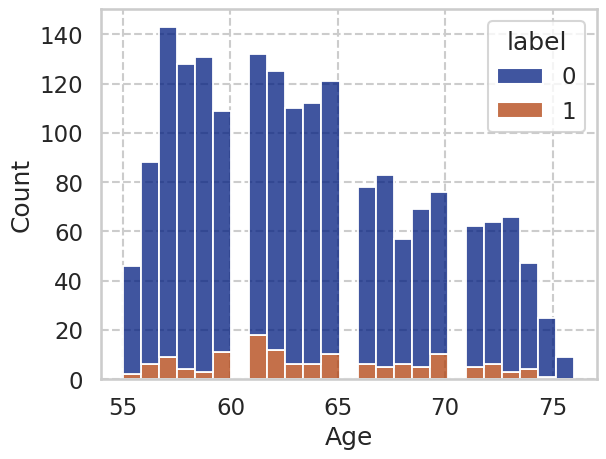

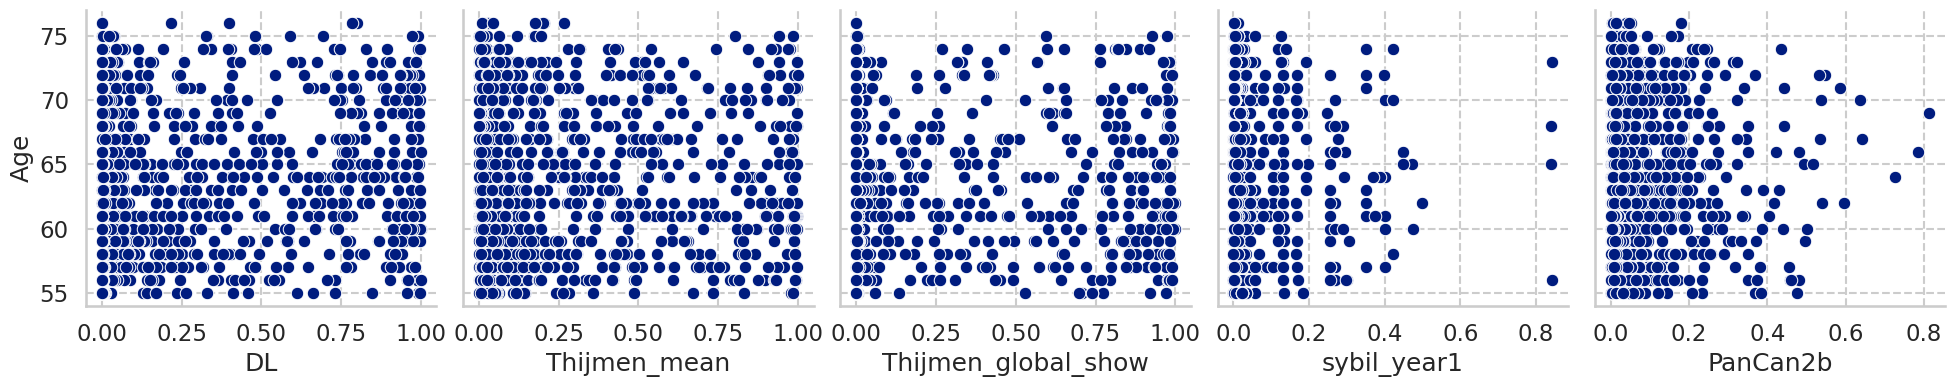

In [13]:
for c in nlst_democols['num']['demo']:
    print(f"{c}: {nlst_preds[c].isna().sum()} null values")
    display(calc_corr(nlst_preds, c, MODEL_TO_COL))
    sns.histplot(nlst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(nlst_preds, x_vars=MODEL_TO_COL.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()

### smoking columns

pkyr: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.096057,0.000030,0.051083,0.140643,0.093567,0.001233
de Haas Combined,0.045571,0.048139,0.000375,0.090581,0.124046,0.000531
de Haas Global (shown nodule),0.069995,0.002386,0.024878,0.114828,0.085827,0.000868
Sybil,0.046580,0.043391,0.001386,0.091583,0.024512,0.000162
PanCan2b,0.044448,0.053931,-0.000750,0.089464,0.040936,0.000173


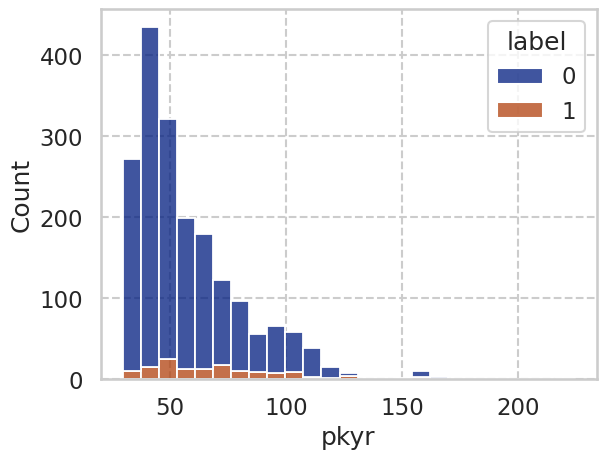

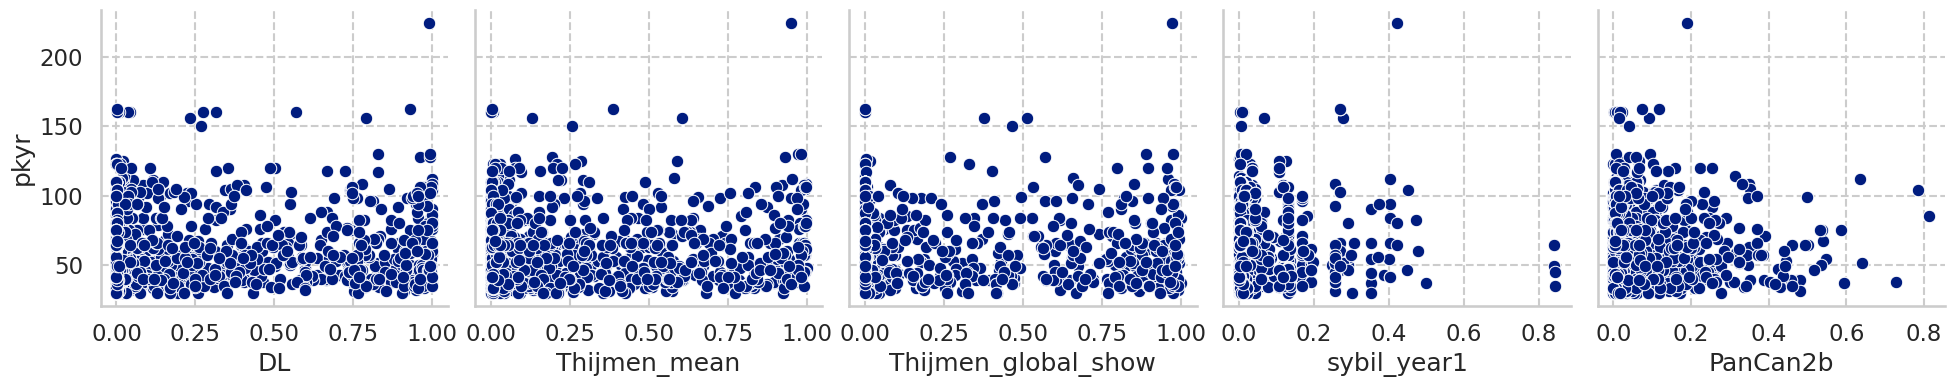

smokeage: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.005398,0.815012,-0.050582,0.039808,0.173227,-0.000483
de Haas Combined,0.010562,0.647099,-0.034651,0.055732,0.140882,0.000858
de Haas Global (shown nodule),-0.047233,0.040530,-0.092233,-0.002041,0.203267,-0.004079
Sybil,0.046520,0.043659,0.001326,0.091524,0.015432,0.001128
PanCan2b,-0.024780,0.282755,-0.069898,0.020440,0.062014,-0.000671


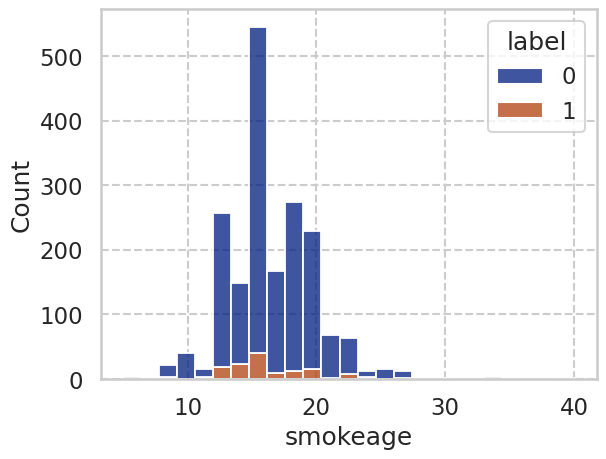

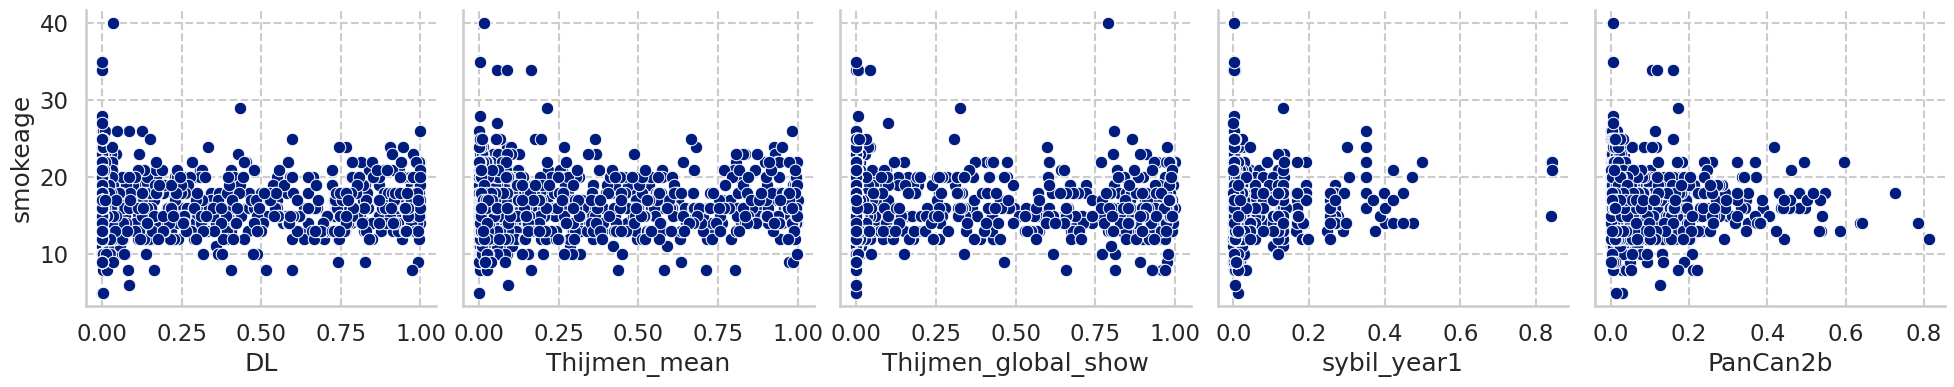

smokeday: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.026453,0.251501,-0.018766,0.071564,0.146765,0.000643
de Haas Combined,-0.026577,0.249274,-0.071688,0.018641,0.171877,-0.000587
de Haas Global (shown nodule),0.024018,0.297822,-0.021202,0.069139,0.120062,0.000564
Sybil,-0.005798,0.801596,-0.050981,0.039409,0.035053,-0.000038
PanCan2b,-0.019275,0.403445,-0.064415,0.025944,0.055090,-0.000142


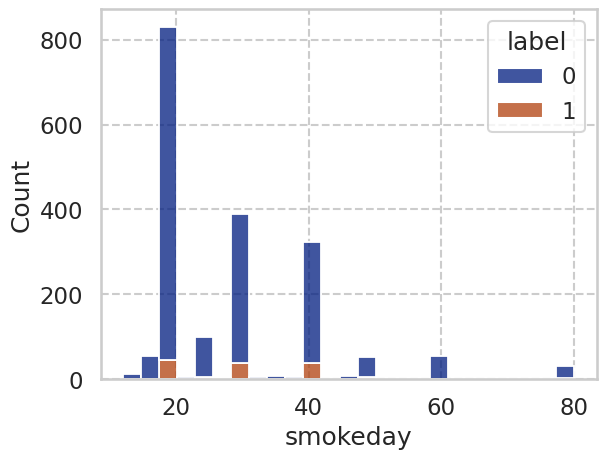

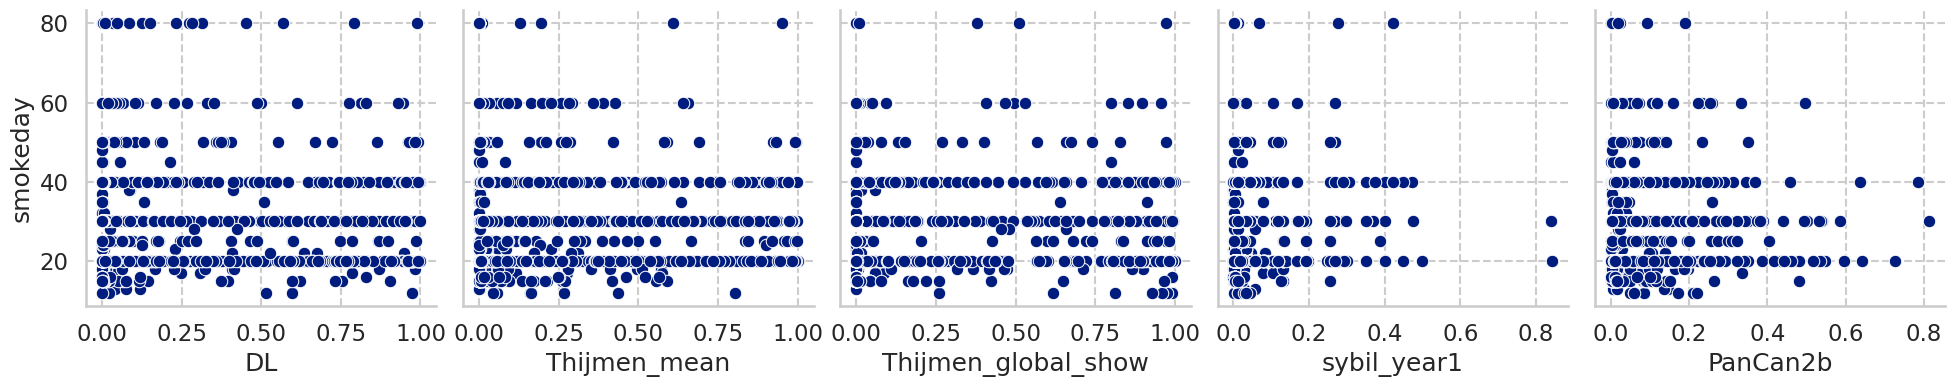

smokeyr: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.093567,0.000048,0.048576,0.138179,0.016934,0.003585
de Haas Combined,0.089428,0.000103,0.044411,0.134083,0.026161,0.003112
de Haas Global (shown nodule),0.045945,0.046328,0.000750,0.090953,0.065947,0.001700
Sybil,0.067846,0.003241,0.022719,0.112697,0.004762,0.000705
PanCan2b,0.101609,0.000010,0.056673,0.146135,0.002168,0.001180


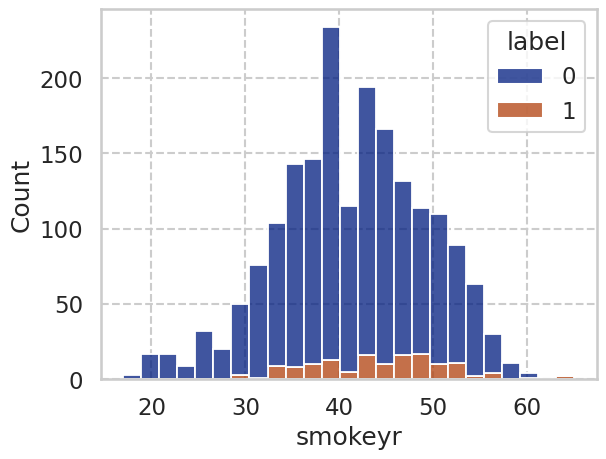

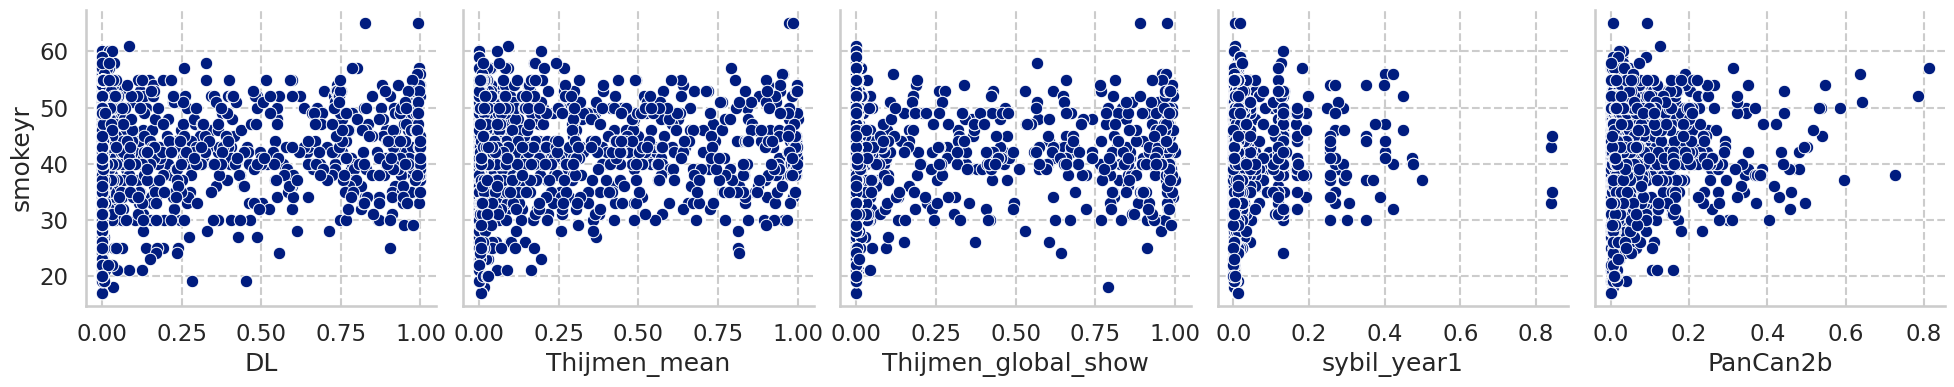

In [15]:
for c in nlst_democols['num']['smoke']:
    print(f"{c}: {nlst_preds[c].isna().sum()} null values")
    display(calc_corr(nlst_preds, c, MODEL_TO_COL))
    sns.histplot(nlst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(nlst_preds, x_vars=MODEL_TO_COL.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()

## DLCST: load data

In [16]:
dlcst_preds = pd.read_csv(f"{EXPERIMENT_DIR}/dlcst/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [17]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [18]:
dlcst_democols = ['Age', 'Sex', 'FamilyHistoryLungCa', 'Emphysema', 'NoduleCountPerScan']

## DLCST: How are the columns related with predictions?

Age: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.247181,8.656852e-10,0.170445,0.320937,-0.719407,0.014823
de Haas,0.235409,5.489193e-09,0.158282,0.309680,-0.505021,0.011492
Sybil,0.200870,7.176448e-07,0.122734,0.276531,-0.165130,0.003272
PanCan2b,0.236092,4.944109e-09,0.158988,0.310334,-0.275032,0.005667


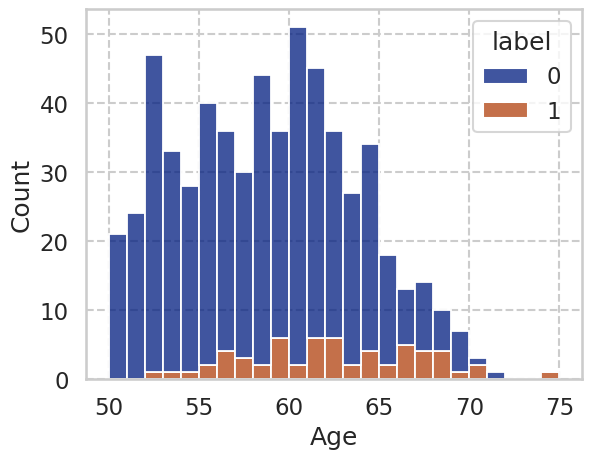

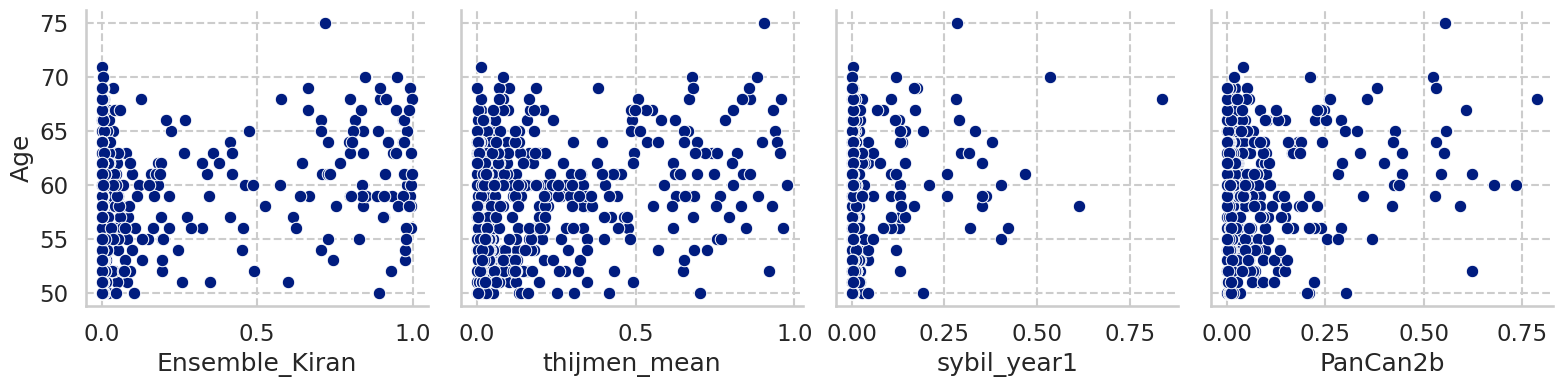

Sex: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.053005,0.195157,-0.027222,0.132553,0.100164,0.031514
de Haas,0.025611,0.531572,-0.054612,0.105506,0.147987,0.012396
Sybil,0.009073,0.824633,-0.071090,0.089119,0.023824,0.001465
PanCan2b,0.104967,0.010148,0.025067,0.183535,0.019412,0.024980


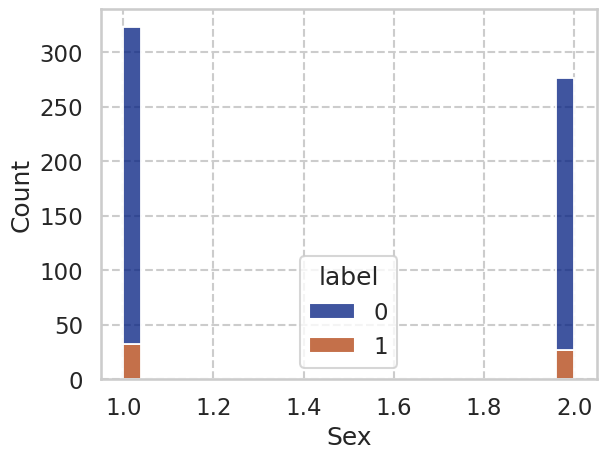

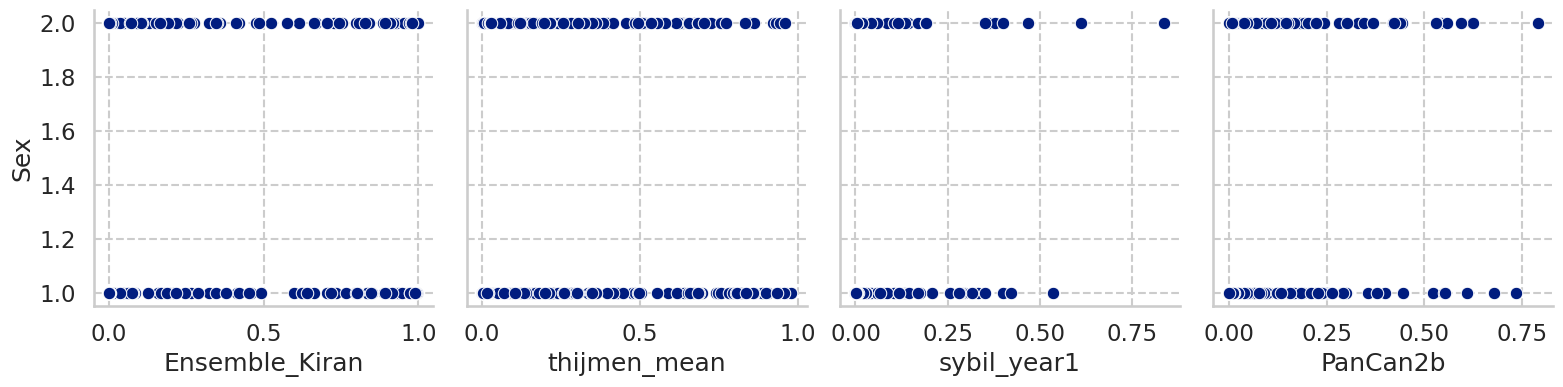

FamilyHistoryLungCa: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.082711,0.043017,0.002617,0.161750,0.135094,0.065212
de Haas,0.072589,0.075863,-0.007566,0.151817,0.158161,0.046591
Sybil,0.097491,0.016998,0.017517,0.176226,0.022409,0.020881
PanCan2b,0.104386,0.010574,0.024480,0.182968,0.050292,0.032943


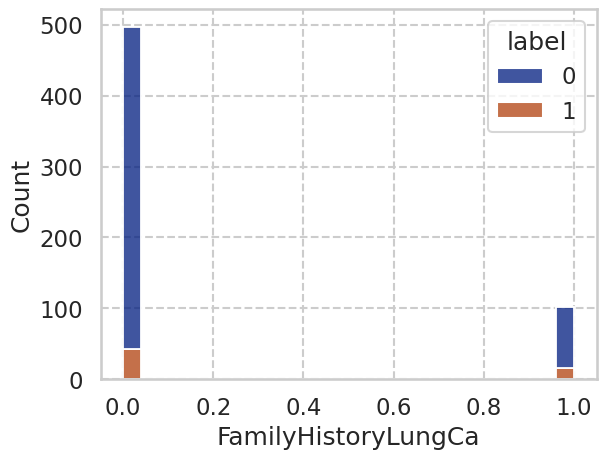

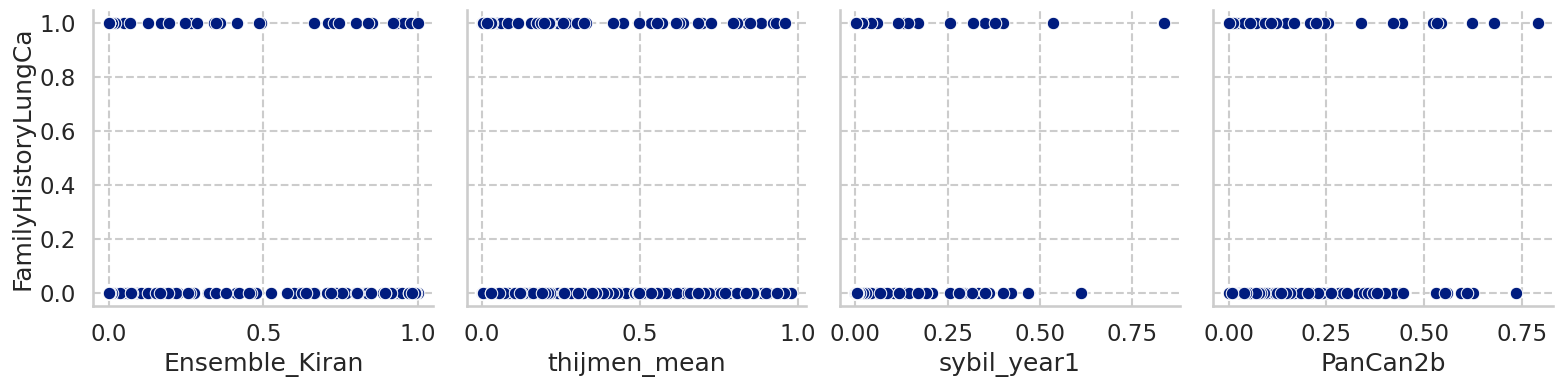

Emphysema: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.126122,0.001984,0.046480,0.204170,0.092194,0.079873
de Haas,0.130667,0.001350,0.051091,0.208595,0.120546,0.067367
Sybil,0.090251,0.027193,0.010214,0.169139,0.015467,0.015527
PanCan2b,0.120324,0.003184,0.040604,0.198521,0.035279,0.030501


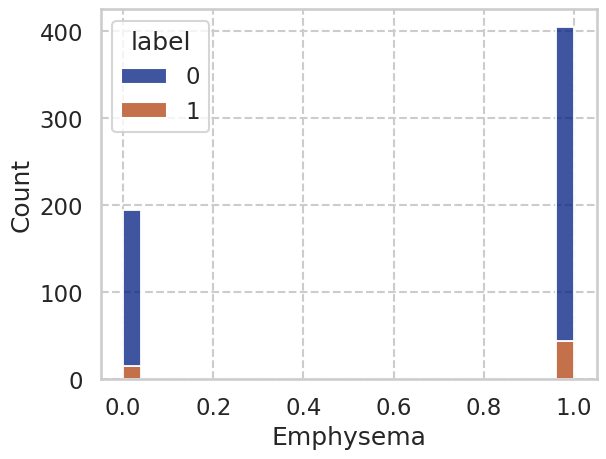

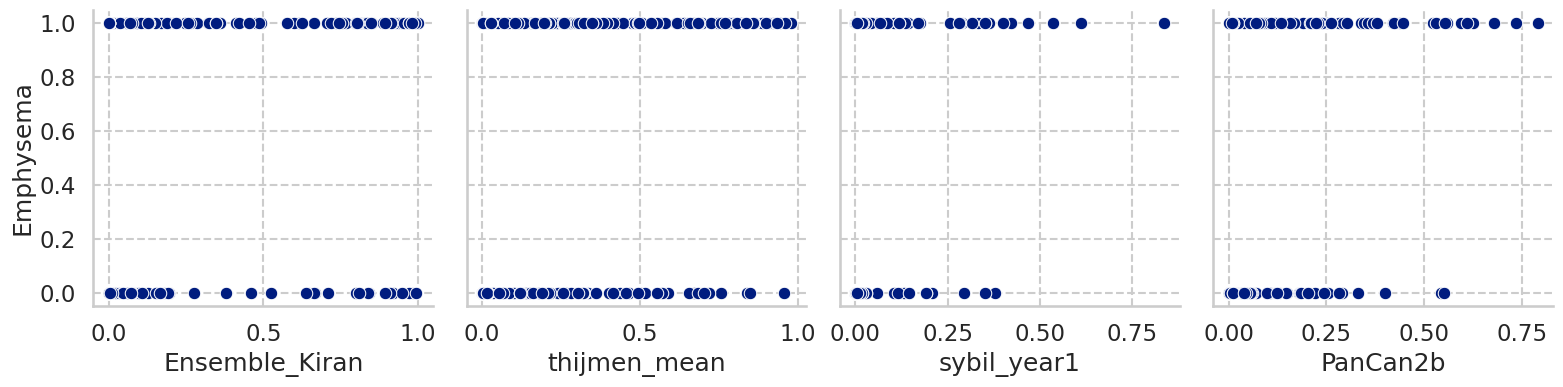

NoduleCountPerScan: 0 null values


,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.020460,0.617247,-0.100407,0.059749,0.155413,-0.005207
de Haas,-0.061364,0.133578,-0.140784,0.018839,0.188593,-0.012714
Sybil,-0.052081,0.203066,-0.131643,0.028147,0.032337,-0.003601
PanCan2b,-0.058249,0.154488,-0.137718,0.021964,0.066402,-0.005934


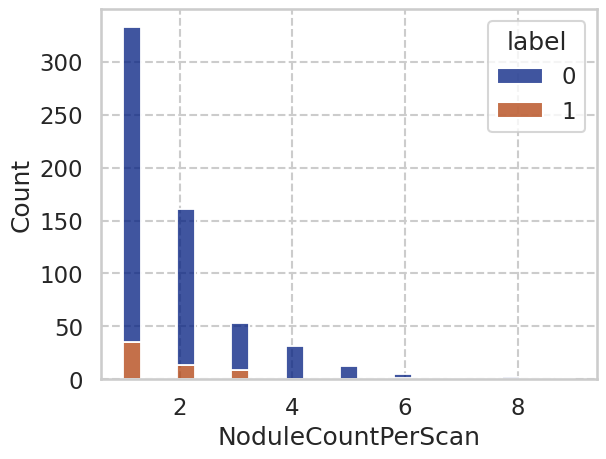

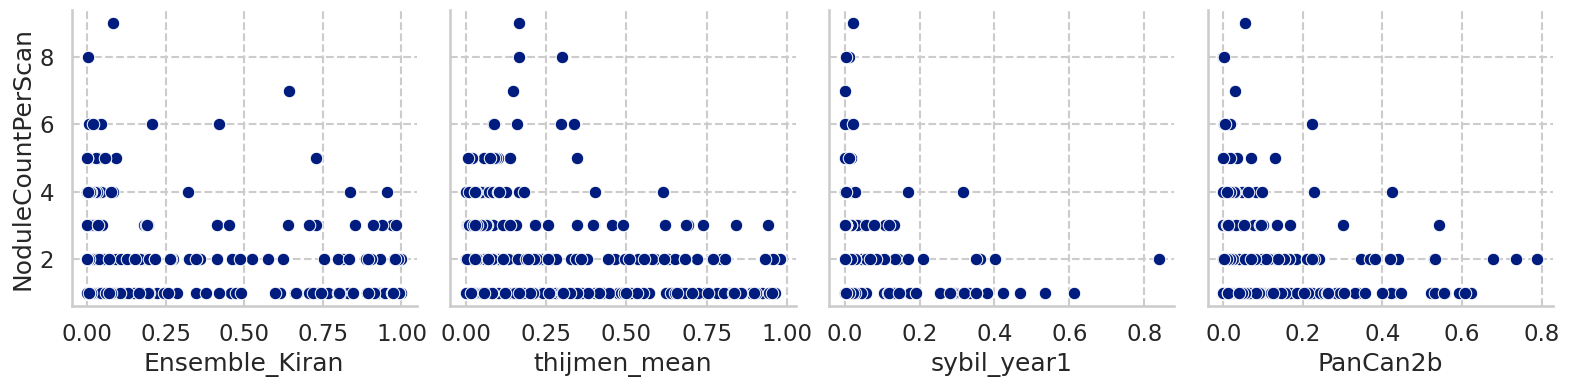

In [20]:
for c in dlcst_democols:
    print(f"{c}: {dlcst_preds[c].isna().sum()} null values")
    display(calc_corr(dlcst_preds, c, MODEL_TO_COL))
    sns.histplot(dlcst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(dlcst_preds, x_vars=MODEL_TO_COL.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()